## NCEP_CPC_IRmerge 
Download GPM_IRmerge brightness temperature data from GESDISC archive

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cfgrib
import cf2cdm
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import xarray as xr
from datetime import datetime, timedelta
import urllib.request
from cfgrib.xarray_store import open_dataset
import warnings
import h5py
import time

In [2]:
warnings.filterwarnings('ignore')

In [3]:
os.chdir('/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/pic/')
file = np.loadtxt('rms_timeseriesResidual_ramp.txt',skiprows=4)
date_acqui = []
for t in range(file.shape[0]):
    date_acqui.append(str(file[t,0])[:8]) # times of acquisitions

https://disc2.gesdisc.eosdis.nasa.gov/data/MERGED_IR/GPM_MERGIR.1/2015/012/merg_2015011203_4km-pixel.nc4

In [4]:
date_acqui

['20150322',
 '20150403',
 '20150415',
 '20150509',
 '20150626',
 '20150720',
 '20150906',
 '20160104',
 '20160221',
 '20160316',
 '20160409',
 '20160503',
 '20160527',
 '20160714',
 '20160807',
 '20161105',
 '20161129',
 '20161223',
 '20170116',
 '20170305',
 '20170317',
 '20170422',
 '20170516',
 '20170528',
 '20170609',
 '20170621',
 '20170703',
 '20170715',
 '20170727',
 '20170808',
 '20170820',
 '20170901',
 '20170913',
 '20170925',
 '20171007',
 '20171019',
 '20171031',
 '20171112',
 '20171124',
 '20171206',
 '20171218',
 '20171230',
 '20180111',
 '20180123',
 '20180204',
 '20180216',
 '20180228',
 '20180312',
 '20180324',
 '20180405',
 '20180417',
 '20180429',
 '20180511',
 '20180523',
 '20180604',
 '20180616',
 '20180710',
 '20180722',
 '20180803',
 '20180815',
 '20180908',
 '20180920',
 '20181002',
 '20181014',
 '20181026',
 '20181107',
 '20181119',
 '20181201',
 '20181213',
 '20181225',
 '20190106',
 '20190118',
 '20190130',
 '20190211',
 '20190223',
 '20190319',
 '20190331',

In [15]:
os.chdir('/data2/willytsai/InSAR_HRRR/NCEP_CPC_IRmerge')
for date in date_acqui:
    print(date)
    yr = date[:4]
    mon = date[4:6]
    day = date[6:8]
    
    day_in_yr = time.strptime(date, "%Y%m%d").tm_yday # convert into number of day in a year
    if day_in_yr < 10:
        day_folder = '00' + str(day_in_yr)
    elif (day_in_yr >= 10) and (day_in_yr < 100):
        day_folder = '0' + str(day_in_yr)
    else:
        day_folder = str(day_in_yr)
    
    cmmd = str('wget --user=willyqq9115 --password=As@23082606 https://disc2.gesdisc.eosdis.nasa.gov/data/MERGED_IR/GPM_MERGIR.1/'+ 
            yr +'/'+ day_folder + '/merg_' + date + '02_4km-pixel.nc4')
    os.system(cmmd)

20150322
20150403
20150415
20150509
20150626
20150720
20150906
20160104
20160221
20160316
20160409
20160503
20160527
20160714
20160807
20161105
20161129
20161223
20170116
20170305
20170317
20170422
20170516
20170528
20170609
20170621
20170703
20170715
20170727
20170808
20170820
20170901
20170913
20170925
20171007
20171019
20171031
20171112
20171124
20171206
20171218
20171230
20180111
20180123
20180204
20180216
20180228
20180312
20180324
20180405
20180417
20180429
20180511
20180523
20180604
20180616
20180710
20180722
20180803
20180815
20180908
20180920
20181002
20181014
20181026
20181107
20181119
20181201
20181213
20181225
20190106
20190118
20190130
20190211
20190223
20190319
20190331
20190412
20190424
20190506
20190518
20190530
20190611
20190623
20190705
20190717
20190729
20190810
20190822
20190903
20190915
20190927
20191009
20191021
20191102
20191114
20191126
20191208
20191220
20200301
20200313
20200325
20200406
20200418
20200430
20200512
20200524
20200605
20200617
20200629
20200711
2

### Select targeted region and merge all acquisition into one netcdf file
geometryRadar.h5 provides the bound of view

In [2]:
geo_file = '/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/inputs/geometryRadar.h5'
geo = h5py.File(geo_file,'r')
# for key in geo.keys():
#     print(key) #Names of the groups in HDF5 file.
lat = geo['latitude'];
lon = geo['longitude'];
incidence = geo['incidenceAngle'];
axis_bound = [np.min(lat),np.max(lat),np.min(lon),np.max(lon)]; # coordinate bound [South,North,West,East]
axis_bound = [np.unique(lat.value)[1],np.unique(lat.value)[-1],np.unique(lon.value)[0],np.unique(lon.value)[-2]]
axis_bound

/home/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':


[37.228, 43.223568, -119.00549, -114.65358]

In [3]:
# have some IR information from NCEP_CPC_IRmerge
os.chdir('/data2/willytsai/InSAR_HRRR/NCEP_CPC_IRmerge/')
IR_files = sorted(glob('*.nc4'))
len(IR_files)

118

In [5]:
data_ir = xr.open_dataset(IR_files[0])
Tb = data_ir.sel(lat=slice(axis_bound[0],axis_bound[1]),lon=slice(axis_bound[2],axis_bound[3])).Tb

In [6]:
Tb

<xarray.DataArray 'Tb' (time: 2, lat: 165, lon: 119)>
array([[[260., 258., ...,  nan,  nan],
        [260., 258., ...,  nan,  nan],
        ...,
        [277., 275., ..., 280., 279.],
        [277., 275., ..., 279., 279.]],

       [[264., 265., ..., 278., 277.],
        [268., 269., ..., 271., 256.],
        ...,
        [276., 276., ..., 275., 275.],
        [276., 276., ..., 273., 274.]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -118.97534 -118.938965 ... -114.71908 -114.6827
  * lat      (lat) float32 37.24075 37.27714 37.313526 ... 43.17162 43.208004
  * time     (time) datetime64[ns] 2015-03-22T02:00:00.000013312 2015-03-22T0...
Attributes:
    units:          K
    standard_name:  brightness_temperature

In [32]:
data_ir = xr.open_dataset(IR_files[0])
tmp = data_ir.sel(lat=slice(axis_bound[0],axis_bound[1]),lon=slice(axis_bound[2],axis_bound[3])).Tb
# array for output
Tb_acqu = np.empty((len(IR_files),len(tmp.lat),len(tmp.lon)))

date_frame = []
for n, file in enumerate(IR_files):
    date_frame.append(datetime.strptime(file[5:15],'%Y%m%d%H'))

    data_ir = xr.open_dataset(file)
    Tb = data_ir.sel(lat=slice(axis_bound[0],axis_bound[1]),lon=slice(axis_bound[2],axis_bound[3])).Tb
    Tb_out = Tb[0,:,:]
    Tb_acqu[n,:,:] = Tb_out

In [35]:
Tb_acqu_xr = xr.DataArray(Tb_acqu,dims=('time','latitude','longitude')
                            ,coords=(date_frame,Tb.lat,Tb.lon),name='Tb')
Tb_ds = Tb_acqu_xr.to_dataset(name='Tb')
Tb_ds.to_netcdf('/data2/willytsai/InSAR_HRRR/NCEP_CPC_IRmerge/NCEP_CPC_Tb_NEVADA.nc')

In [36]:
test = xr.open_dataset('/data2/willytsai/InSAR_HRRR/NCEP_CPC_IRmerge/NCEP_CPC_Tb_NEVADA.nc')

In [9]:
test2 = xr.open_dataset('/data2/willytsai/InSAR_HRRR/auto_framework/NCEP_CPC_IRmerge/NCEP_CPC_Tb_NEVADA.nc')

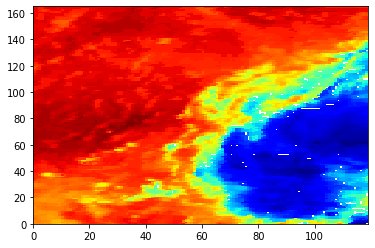

In [48]:
plt.pcolor(test.Tb[58,:,:],cmap='jet')

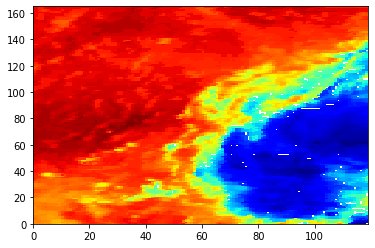

In [10]:
plt.pcolor(test2.Tb[58,:,:],cmap='jet')